In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle
import emcee
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [2]:
class ROSATxLike(object):
    def __init__(self,
                 params_vary=['lMc', 'alpha_T'],
                 priors={'lMc': [13.0, 15.0], 'alpha_T': [0.1, 2.0]},
                 bins=[0, 1, 2, 3]):
        self.params_vary = params_vary
        self.priors = priors
        # Load data
        s = sacc.Sacc.load_fits('data/cls_cov.fits')
        # Remove all other tracers
        s.remove_tracers(['CatWISE'] + [f'WIxSCx2M__{i}' for i in range(6)])
        # Scale cuts
        s.keep_selection(ell__gt=30, ell__lt=2048)
        self.bins = bins
        # Read info about all C_ells and the dNdzs
        indices = []
        self.cl_meta = []
        self.dndzs = {}
        for i in self.bins:
            tn = f'DESY1wl__{i}'
            leff, cld, cov, ind = s.get_ell_cl('cl_0e','ROSAT', tn, return_cov=True, return_ind=True)
            indices += list(ind)
            self.cl_meta.append({'t1': 'ROSAT',
                                 't2': tn,
                                 'ls': leff,
                                 'cld': cld,
                                 'cov': cov,
                                 'ind': ind,
                                 'beam': self.beam(leff)})
            tr = s.tracers[tn]
            self.dndzs[tn] = (tr.z, tr.nz)
        indices = np.array(indices)

        # Reorganise data
        self.data = s.mean[indices]
        self.cov = s.covariance.dense[indices][:, indices]
        self.inv_cov = np.linalg.inv(self.cov)
        self.ndata = len(self.data)

        # Get X-ray spectrum
        self.get_spectrum()

        # Initialise theory model
        self.init_model()

    def beam(self, ell, nside=1024):
        fwhm_hpx_amin = 60*41.7/nside
        sigma_hpx = np.radians(fwhm_hpx_amin/60)/2.355
        sigma_ROSAT = np.radians(1.8e0/60)/2.355
        sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_hpx**2
        return np.exp(-0.5*sigma_tot_2*ell*(ell+1))

    def get_spectrum(self):
        kTmin = 0.02
        kTmax = 50.0
        nkT = 32
        zmax = 4.0
        nz = 16
        emin = 0.5
        emax = 2.0

        if os.path.isfile("data/Jtot.pck"):
            with open("data/Jtot.pck", "rb") as f:
                J_tot = pickle.load(f)
        else:
            rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
            J_tot = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)
            with open("data/Jtot.pck", "wb") as f:
                pickle.dump(J_tot, f)
        if os.path.isfile("data/Jcont.pck"):
            with open("data/Jcont.pck", "rb") as f:
                J_cont = pickle.load(f)
        else:
            rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
            J_cont = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                                                   dolines=False, dopseudo=False)
            with open("data/Jcont.pck", "wb") as f:
                pickle.dump(J_cont, f)
        self.J_tot = J_tot
        self.J_cont = J_cont

    def init_model(self):
        COSMO_P18 = {"Omega_c": 0.26066676,
                     "Omega_b": 0.048974682,
                     "h": 0.6766,
                     "n_s": 0.9665,
                     "sigma8": 0.8102,
                     "matter_power_spectrum": "linear"}
        self.cosmo = ccl.Cosmology(**COSMO_P18)
        mdef = ccl.halos.MassDef200c
        cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
        nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
        bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
        self.hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=mdef,
                                          log10M_max=15., log10M_min=10, nM=32)
        self.prof_dens = rx.HaloProfileDensityHE(mass_def=mdef,
                                                 concentration=cM,
                                                 kind='n_total')
        self.prof_pres = rx.HaloProfilePressureHE(mass_def=mdef,
                                                  concentration=cM,
                                                  kind='n_total')
        self.prof_matter = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)
        self.prof_xray = rx.HaloProfileXray(mass_def=mdef, Jinterp=self.J_tot,
                                            dens=self.prof_dens, pres=self.prof_pres,
                                            fourier_approx=False)
        # Initialize tracers
        self.tx = rx.XrayTracer(self.cosmo)
        self.tgs = {k: ccl.WeakLensingTracer(self.cosmo, dndz=v) for k, v in self.dndzs.items()}

        # Fixed k and a arrays
        k_arr = np.geomspace(1e-4, 100, 256)
        self.lk_arr = np.log(k_arr)
        self.a_arr = np.linspace(0.3,1,8)

    def default_params(self):
        return {'lMc': 14.0, 'alpha_T': 1.0}

    def params_to_dict(self, pvec):
        pdict = self.default_params() 
        for k, v in zip(self.params_vary, pvec):
            pdict[k] = v
        return pdict

    def update_params(self, pdict):
        self.prof_dens.update_parameters(lMc=pdict['lMc'], alpha_T=pdict['alpha_T'])
        self.prof_pres.update_parameters(lMc=pdict['lMc'], alpha_T=pdict['alpha_T'])

    def get_model(self, **kwargs):
        self.update_params(kwargs)
        pkx = ccl.halos.halomod_Pk2D(self.cosmo, self.hmc,
                                     self.prof_matter, prof2=self.prof_xray,
                                     lk_arr=self.lk_arr, a_arr=self.a_arr)
        cls = []
        for clm in self.cl_meta:
            clt = ccl.angular_cl(self.cosmo,
                                 self.tx, self.tgs[clm['t2']],
                                 clm['ls'], p_of_k_a=pkx)
            bm = clm['beam']
            cls.append(clt*bm)
        return cls

    def get_prior(self, pdict):
        for k in self.params_vary:
            p0, pf = self.priors[k]
            p = pdict[k]
            if (p > pf) or (p < p0):
                return True
        return False

    def get_logp(self, **kwargs):
        if self.get_prior(kwargs):
            return -np.inf
        t = np.concatenate(self.get_model(**kwargs))
        r = self.data - t
        return -0.5*np.dot(r, np.dot(self.inv_cov, r))

    def logp(self, pvec):
        pdict = self.params_to_dict(pvec)
        return self.get_logp(**pdict)

196.87562070420364
[73.09183245806265, 51.91743405193792, 107.14430302033328, 56.925342718342044, 51.91743405193792, 98.469538645807]
96


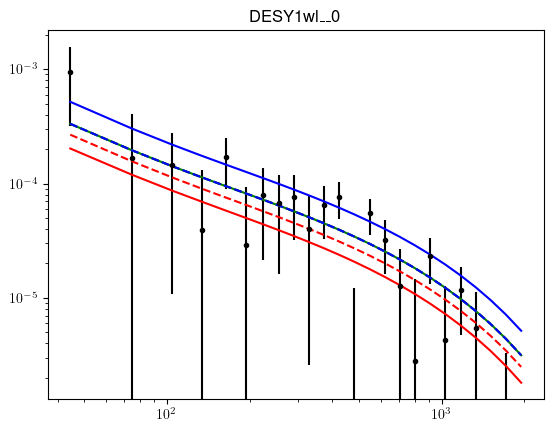

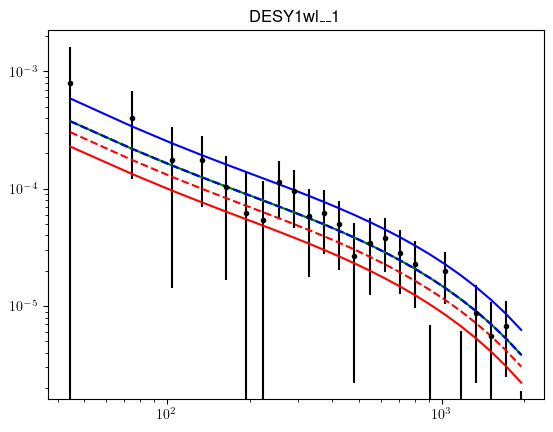

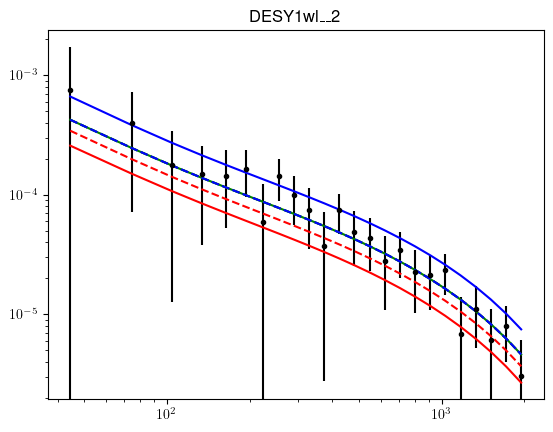

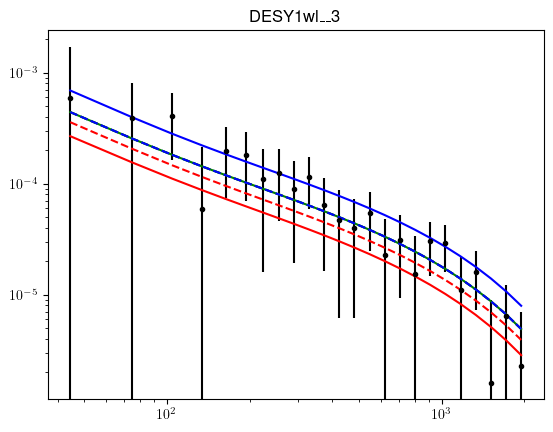

In [4]:
l = ROSATxLike()
chi20 = np.dot(l.data, np.dot(l.inv_cov, l.data))
print(chi20)

pars = [{'lMc': 14.6, 'alpha_T': 1.0},
        {'lMc': 14.3, 'alpha_T': 1.0},
        {'lMc': 14.0, 'alpha_T': 1.0},
        {'lMc': 14.3, 'alpha_T': 1.5},
        {'lMc': 14.3, 'alpha_T': 1.0},
        {'lMc': 14.3, 'alpha_T': 0.5}]
clms = [l.get_model(**p) for p in pars]
chi2s = [-2*l.get_logp(**p) for p in pars]
print(chi2s)
print(l.ndata)

for i, d in enumerate(l.cl_meta):
    plt.figure()
    plt.title(d['t2'])
    plt.errorbar(d['ls'], d['cld'],
                 yerr=np.sqrt(np.diag(d['cov'])),
                 fmt='k.')
    plt.plot(d['ls'], clms[0][i], 'r-')
    plt.plot(d['ls'], clms[1][i], 'g-')
    plt.plot(d['ls'], clms[2][i], 'b-')
    plt.plot(d['ls'], clms[3][i], 'r--')
    plt.plot(d['ls'], clms[4][i], 'g--')
    plt.plot(d['ls'], clms[4][i], 'b--')
    plt.loglog()


In [5]:
print(np.sqrt(chi20-np.amin(np.array(chi2s))))

12.039858248844366


In [6]:
pBF = np.array(list(pars[np.argmin(chi2s)].values()))
print(pBF)

[14.3  1. ]


In [7]:
lMcs = np.linspace(14.1, 14.6, 32)
chi2_lMc = np.array([-2*l.logp([lMc, 1.0]) for lMc in lMcs])

alpha_Ts = np.linspace(0.6, 1.8, 32)
chi2_aT = np.array([-2*l.logp([14.3, aT]) for aT in alpha_Ts])

1.0258064516129033 51.860691797693754


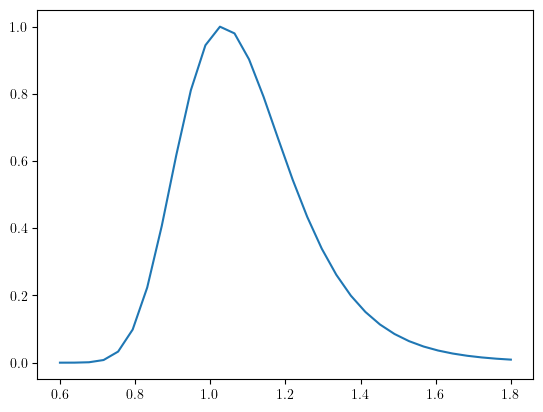

In [8]:
plt.plot(alpha_Ts, np.exp(-(chi2_aT-np.amin(chi2_aT))*0.5))
print(alpha_Ts[np.argmin(chi2_aT)], np.amin(chi2_aT))

14.325806451612904 51.819625480581365


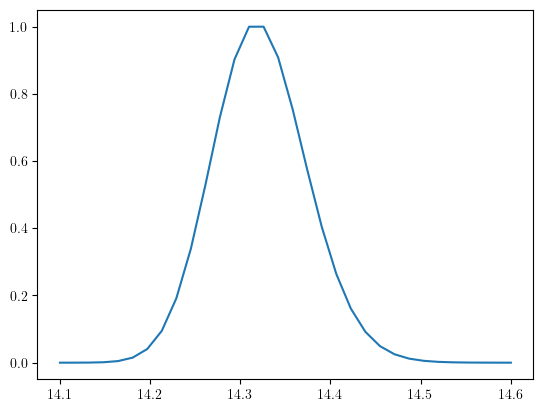

In [9]:
plt.plot(lMcs, np.exp(-(chi2_lMc-np.amin(chi2_lMc))*0.5))
print(lMcs[np.argmin(chi2_lMc)], np.amin(chi2_lMc))

In [ ]:
npars = len(pBF)
nwalkers = 2*npars
nsteps = 10000

pos = (pBF +
       0.001 * np.random.randn(nwalkers, npars))
sampler = emcee.EnsembleSampler(nwalkers, npars, l.logp)
sampler.run_mcmc(pos, nsteps, progress=True)

 22%|████████████████████████████████████▊                                                                                                                                    | 872/4000 [36:38<2:49:28,  3.25s/it]

In [ ]:
chain = sampler.get_chain(discard=0, flat=True)
probs = sampler.get_log_prob(flat=True)
np.savez("chain_Mc_aT_Y3.npz", chain=chain, probs=probs)

(35000, 2)
15.932068264723702
Removed no burn in
(35000, 2)
22.957436309319757
Removed no burn in
(35000, 2)
19.954721794661904
Removed no burn in
(35000, 2)
22.444203301086812
Removed no burn in
(35000, 2)
84.29802562050146
Removed no burn in


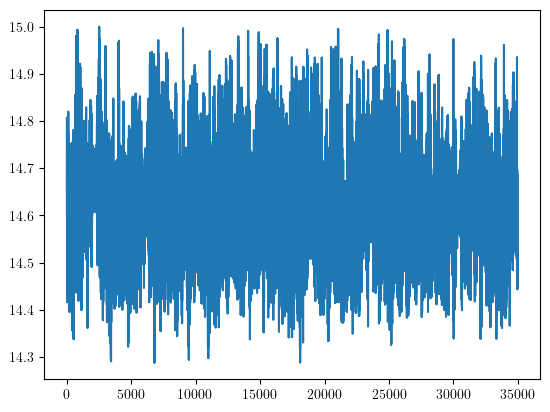

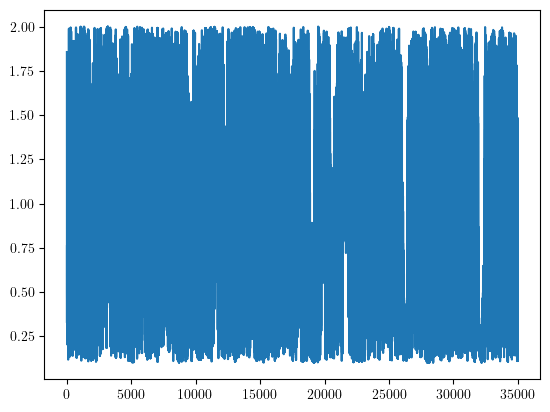

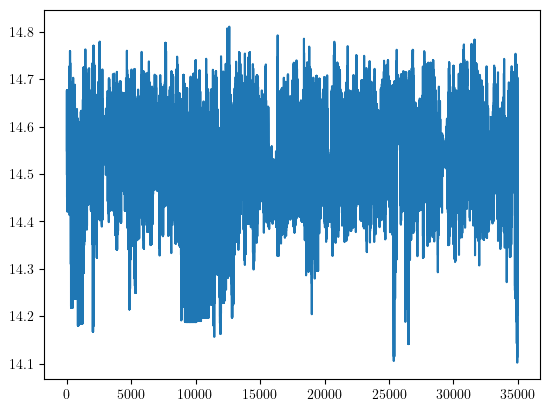

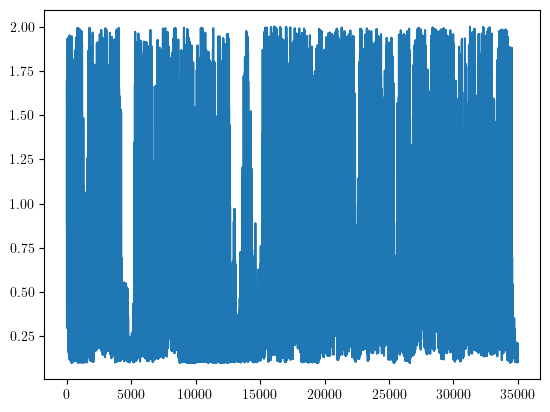

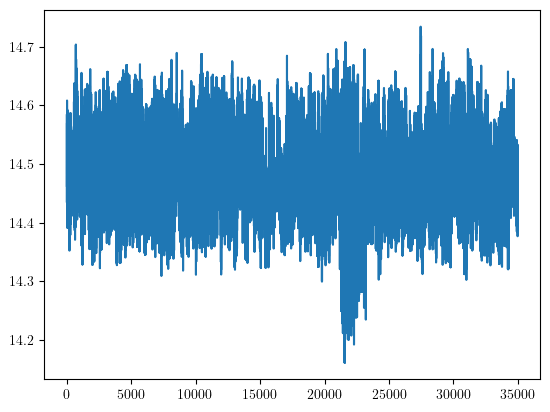

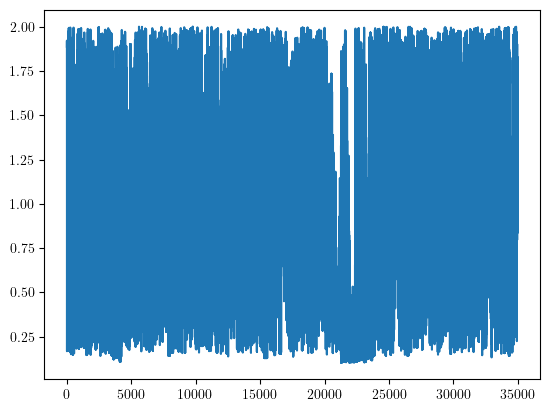

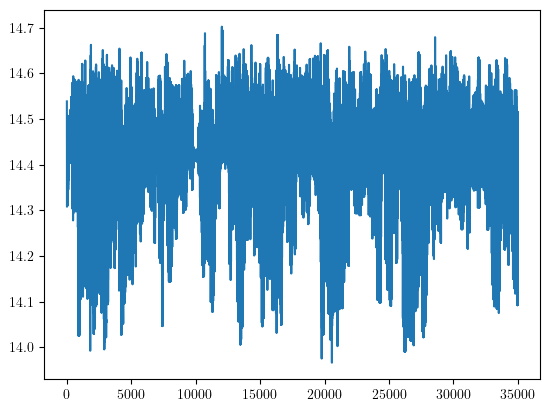

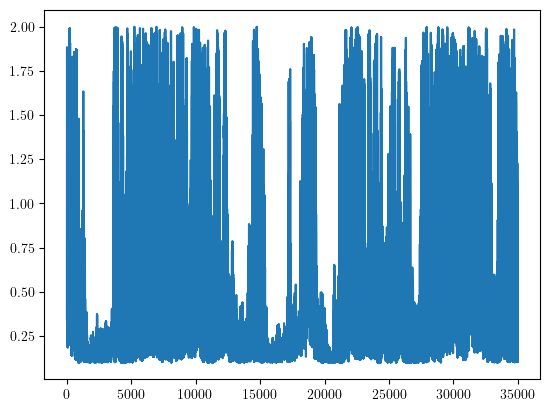

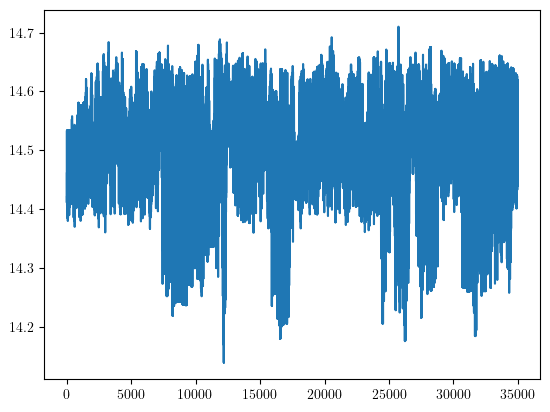

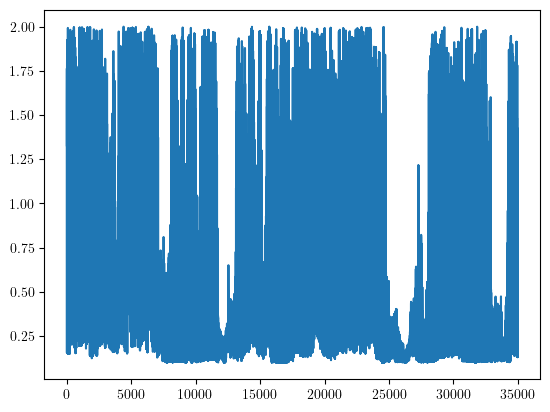

In [2]:
from getdist import MCSamples
from getdist import plots as gplots

samples = {}
for name in [f'bin{j}' for j in range(4)]+['all']:
    d = np.load(f"chain_Mc_aT_Y3_{name}.npz")
    chain = d['chain'][5000:]
    print(chain.shape)
    print(np.amin(-2*d['probs']))
    for i in range(2):
        plt.figure()
        plt.plot(chain[:, i])
    samp = MCSamples(samples=chain,
                     names=['Mc', 'alpha_T'],
                     ranges=[[13, 15], [0.1, 2.0]],
                     labels=[r'$\log_{10}M_c$', r'$\alpha_T$'])
    samp.smooth_scale_2D=0.3
    samples[name] = samp

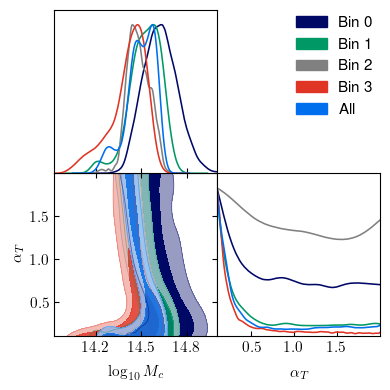

In [3]:
# Triangle plot
#g = gplots.getSubplotPlotter()
#g.triangle_plot([samples['bin0'], samples['bin1'], samples['bin2'], samples['bin3'], samples['all']],
#                filled=True)
g = gplots.get_subplot_plotter()
g.settings.legend_fontsize = 14
g.settings.axes_labelsize = 14
g.settings.axes_fontsize = 14
g.settings.linewidth=2
g.settings.figure_legend_frame=False
g.triangle_plot([samples['bin0'], samples['bin1'], samples['bin2'], samples['bin3'], samples['all']],
                ['Mc', 'alpha_T'],
                ['Bin 0', 'Bin 1', 'Bin 2', 'Bin 3', 'All'],
                filled=[True, True, True, True, True])
#plt.savefig('figs/mrg_survey.pdf', bbox_inches='tight')

(55000, 3)
15.86327066964663
Removed no burn in
(55000, 3)
22.88605258877869
Removed no burn in
(55000, 3)
19.015112304577414
Removed no burn in
(55000, 3)
22.053554211841625
Removed no burn in


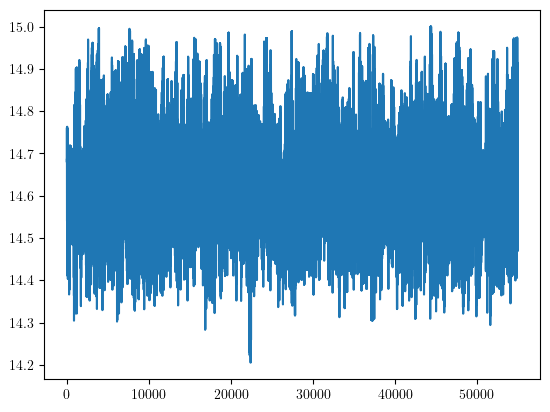

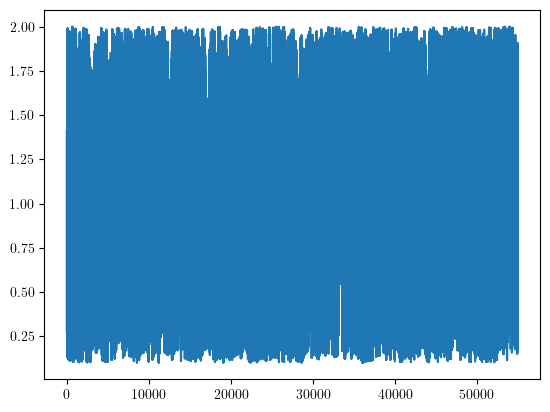

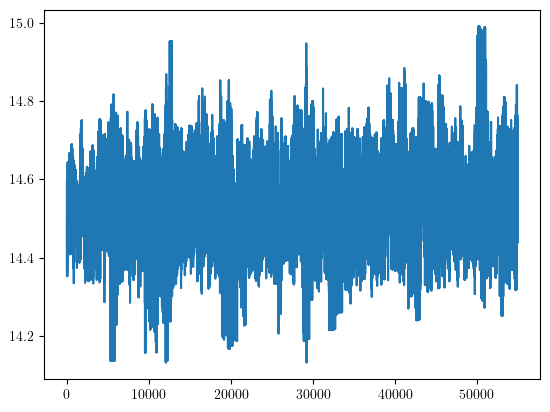

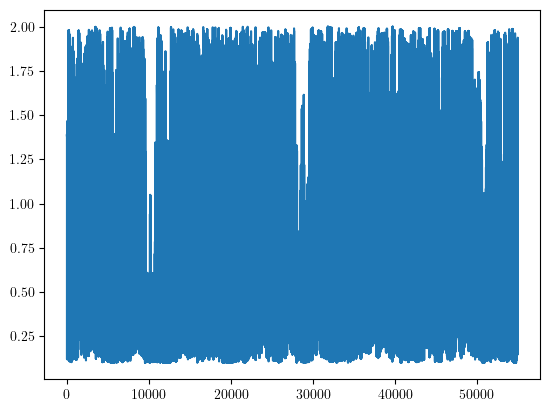

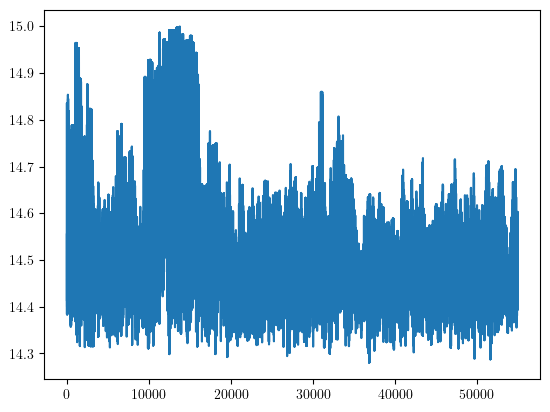

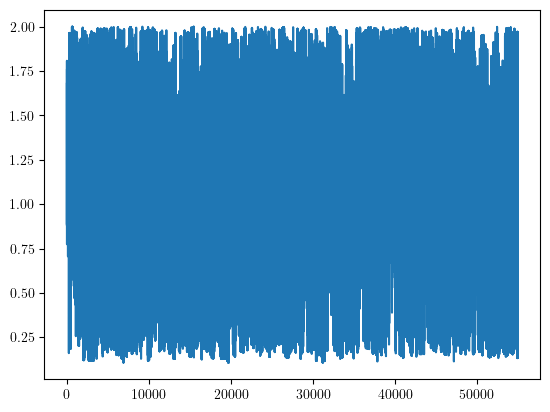

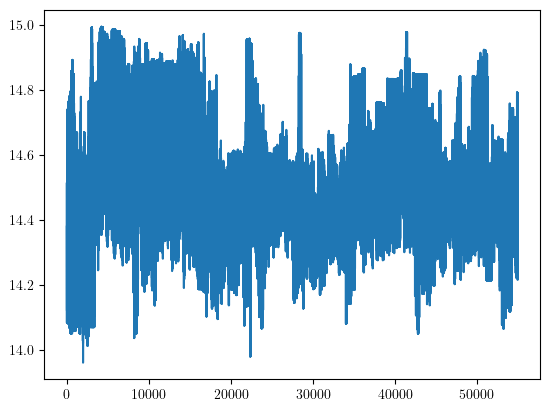

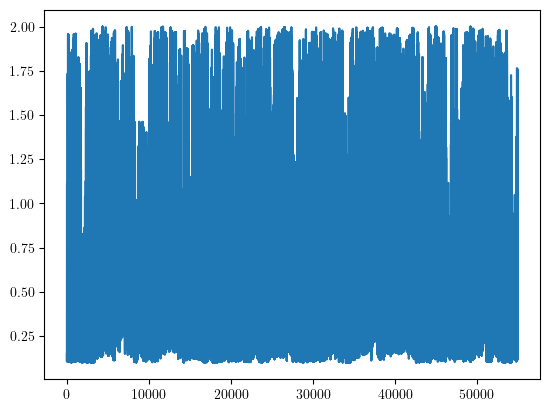

In [4]:
samples = {}
for name in [f'bin{j}' for j in range(4)]:#+['all']:
    d = np.load(f"chain_Mc_aT_etab_Y3_{name}.npz")
    chain = d['chain'][5000:]
    print(chain.shape)
    print(np.amin(-2*d['probs']))
    for i in range(2):
        plt.figure()
        plt.plot(chain[:, i])
    samp = MCSamples(samples=chain,
                     names=['Mc', 'alpha_T', 'eta_b'],
                     ranges=[[13, 15], [0.1, 2.0], [0.1, 2.0]],
                     labels=[r'$\log_{10}M_c$', r'$\alpha_T$', r'$\eta_b$'])
    samp.smooth_scale_2D=0.3
    samples[name] = samp

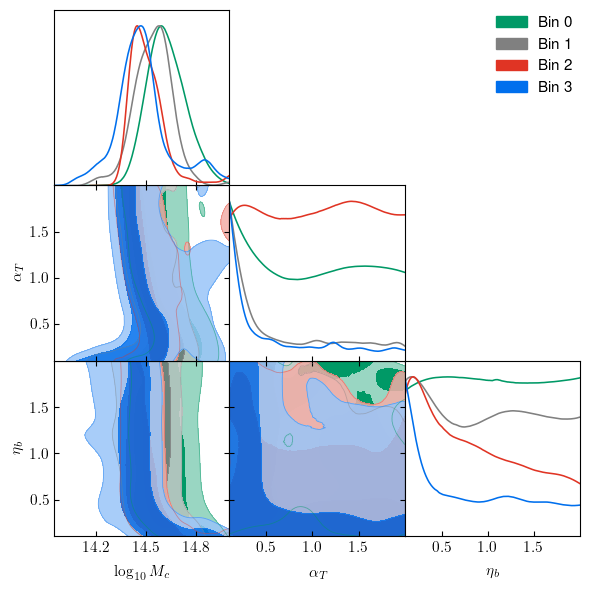

In [5]:
g = gplots.get_subplot_plotter()
g.settings.legend_fontsize = 14
g.settings.axes_labelsize = 14
g.settings.axes_fontsize = 14
g.settings.linewidth=2
g.settings.figure_legend_frame=False
g.triangle_plot([samples['bin0'], samples['bin1'], samples['bin2'], samples['bin3']],
                ['Mc', 'alpha_T', 'eta_b'],
                ['Bin 0', 'Bin 1', 'Bin 2', 'Bin 3'],
                filled=[True, True, True, True])
#plt.savefig('figs/mrg_survey.pdf', bbox_inches='tight')